In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Bidirectional, Lambda
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from tf2crf import CRF, ModelWithCRFLoss

In [3]:
def split_tags(df):
    tokes=[]
    idxs=[]
    sens=[]
    for i in range(len(df)):
        tk = df.iat[i,1].split(" ")
        for t in tk:
            idxs.append(i+1)
            sens.append(df.iat[i,1])
            tokes.append(t)
    newdf = pd.DataFrame({"Record Number":idxs, "Title":sens, "Token":tokes})
    newdf.index = np.arange(1, len(newdf)+1)
    return newdf

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Token"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["BIO_tag"].values.tolist())]
        
        self.grouped = self.data.groupby("Record Number").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [5]:
df = pd.read_csv("df_modified1.csv")

In [6]:
df

,Record Number,Title,Token,BIO_tag,POS
0,1,LOUIS VUITTON M40096 Handbag Priscilla Multi-c...,LOUIS,B-Brand,NNP
1,1,LOUIS VUITTON M40096 Handbag Priscilla Multi-c...,VUITTON,E-Brand,NNP
2,1,LOUIS VUITTON M40096 Handbag Priscilla Multi-c...,M40096,MPN,NNP
3,1,LOUIS VUITTON M40096 Handbag Priscilla Multi-c...,Handbag,Type,NNP
4,1,LOUIS VUITTON M40096 Handbag Priscilla Multi-c...,Priscilla,Model,NNP
...,...,...,...,...,...
78370,r_1999,Convertible Rivet LEATHER Knit Bucket Flap Bag...,Casual,Occasion,NNP
78371,r_1999,Convertible Rivet LEATHER Knit Bucket Flap Bag...,BAG,Type,NNP
78372,r_1999,Convertible Rivet LEATHER Knit Bucket Flap Bag...,from,No Tag,IN
78373,r_1999,Convertible Rivet LEATHER Knit Bucket Flap Bag...,S222,No Tag,NNP


In [7]:
maxlen = max(len(s) for s in list(df['Title']))
maxlen

122

In [8]:
words = list(set(df['Token']))
tags = list(set(df['BIO_tag']))
pos = list(set(df['POS']))

In [9]:
getter=SentenceGetter(df)
sentences = getter.sentences

In [10]:
def get_model_list(f, delim="<|>"):
    with open(f,'r',encoding='utf-8') as f:
        d={}
        while True:
            try:
                line = f.readline()
                line = str(line).split(delim)
                d[str(line[0])]=int(str(line[1]).replace('\n',''))
            except:
                break
    f.close()
    return d

In [11]:
#coded indexing
word2idx = get_model_list("train_words.txt")
pos2idx = get_model_list("pos_tags.txt")
tag2idx = get_model_list("bio_tags.txt")

In [12]:
max_len=128

In [13]:
len(tag2idx)

114

In [14]:
X_word = [[word2idx[w[0]] if w[0] in word2idx.keys() else '1' for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [15]:
X_pos = [[pos2idx[w[1]] if w[1] in pos2idx.keys() else '1' for w in s] for s in sentences]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')

In [16]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [17]:
X_train_w, X_test_w, y_train, y_test = train_test_split(X_word, y, test_size=0.1, random_state=1234)
X_train_pos, X_test_pos, _, _ = train_test_split(X_pos, y, test_size=0.1, random_state=1234)

In [18]:
train_input = [X_train_w, X_train_pos]

In [19]:
train_input = [X_word, X_pos]

In [20]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
#----------Model Setup----------


# input and embedding for words
word_input = Input(shape=(max_len,), name="Word_Inputs")
emb_word = Embedding(input_dim=len(word2idx)+1, output_dim=64, input_length=max_len, mask_zero=True, name="Word_Embed")(word_input)

# input and embedding for parts of speech
pos_input = Input(shape=(max_len,), name="POS_Inputs")
emb_pos = Embedding(input_dim=len(pos2idx)+1, output_dim=32, input_length=max_len, mask_zero=True, name="POS_Embed")(pos_input)

x = concatenate([emb_word, emb_pos], name="Main_Input")
x = SpatialDropout1D(0.2, name="Main_Dropout")(x)

x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)

x_rnn = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)

x = add([x, x_rnn])  # residual connection to the first biLSTM

out = TimeDistributed(Dense(len(tag2idx)+1, activation="softmax"))(x)
model = Model([word_input, pos_input], out, name='Model_2.2')

# x = concatenate([emb_word, emb_pos], name="Main_Input")
# x = SpatialDropout1D(0.2, name="Main_Dropout")(x)
# x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2),name="Main_LSTM")(x)
# out = TimeDistributed(Dense(len(tag2idx)+1, activation="sigmoid"), name="Main_Dense_Output")(x)
# model = Model([word_input, pos_input], out, name='Model_2.2')


In [22]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc",f1_metric])
model.summary()

Model: "Model_2.2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Word_Inputs (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 POS_Inputs (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 Word_Embed (Embedding)         (None, 128, 64)      3799488     ['Word_Inputs[0][0]']            
                                                                                                  
 POS_Embed (Embedding)          (None, 128, 32)      1568        ['POS_Inputs[0][0]']             
                                                                                          

In [23]:
tf.config.run_functions_eagerly(True)

In [24]:
history = model.fit(train_input,
                    np.array(y).reshape(len(y), max_len, 1),
                    batch_size=64, 
                    epochs=12, 
                    validation_split=0.1, 
                    verbose=1)

Epoch 1/12


C:\Users\Tony\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


99/99 [==============================] - 3622s 37s/step - loss: 0.2327 - acc: 0.3684 - f1_metric: 40.4996 - val_loss: 0.1693 - val_acc: 0.5656 - val_f1_metric: 20.3098
Epoch 2/12
99/99 [==============================] - 4048s 41s/step - loss: 0.1229 - acc: 0.6540 - f1_metric: 12.8004 - val_loss: 0.0953 - val_acc: 0.7314 - val_f1_metric: 8.6788
Epoch 3/12
99/99 [==============================] - 4202s 42s/step - loss: 0.0750 - acc: 0.7848 - f1_metric: 6.9921 - val_loss: 0.0640 - val_acc: 0.8183 - val_f1_metric: 5.4788
Epoch 4/12
99/99 [==============================] - 7581s 77s/step - loss: 0.0514 - acc: 0.8511 - f1_metric: 4.6768 - val_loss: 0.0488 - val_acc: 0.8614 - val_f1_metric: 3.8525
Epoch 5/12
99/99 [==============================] - 4370s 44s/step - loss: 0.0380 - acc: 0.8878 - f1_metric: 3.6322 - val_loss: 0.0366 - val_acc: 0.8934 - val_f1_metric: 3.2241
Epoch 6/12
99/99 [==============================] - 4387s 44s/step - loss: 0.0295 - acc: 0.9105 - f1_metric: 2.9533 - val_l

In [25]:
model.save_weights("./model/model_2.2_checkpoint1")

In [26]:
model.save("./model/model_2.2")

INFO:tensorflow:Assets written to: ./model/model_2.2\assets


INFO:tensorflow:Assets written to: ./model/model_2.2\assets


In [27]:
hist = pd.DataFrame(history.history)

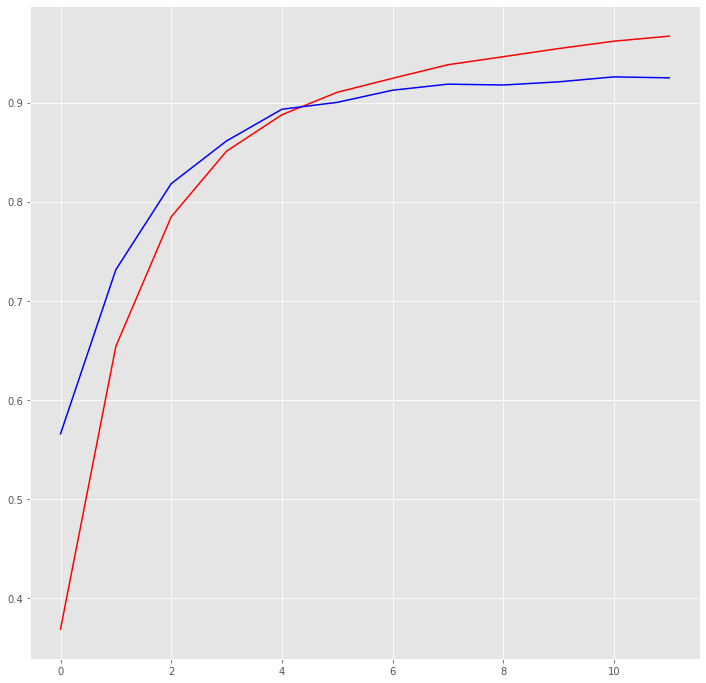

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.show()


In [28]:
test_input = [X_test_w, X_test_pos]

In [29]:
y_pred = model.predict(test_input)

C:\Users\Tony\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 409s 19s/step


In [31]:
np.save("ypred_model2.2",y_pred)